In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import squareform

import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)

from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [3]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['06']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = 0 #0.1 #0.2

In [4]:
with open(local_data_dir + 'processed/06_rh_tessellate_400.data', 'rb') as filehandle:
    # read the data as binary data stream
    mega_matrix = pickle.load(filehandle)

In [5]:
test = mega_matrix[0]
test[test>1] = 1
test[np.isnan(test)] = 0

/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD_venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [6]:
len(test)

95

In [7]:
test[np.diag_indices(len(test))] = 1 #fix diagonal

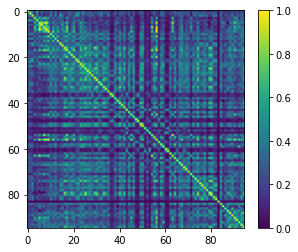

In [8]:
plt.imshow(test)
plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

In [9]:
sym_mm = np.around(test, decimals = 5)
dists = squareform(1-sym_mm)

In [10]:
linkage_matrix = linkage(dists, "complete", optimal_ordering=True)


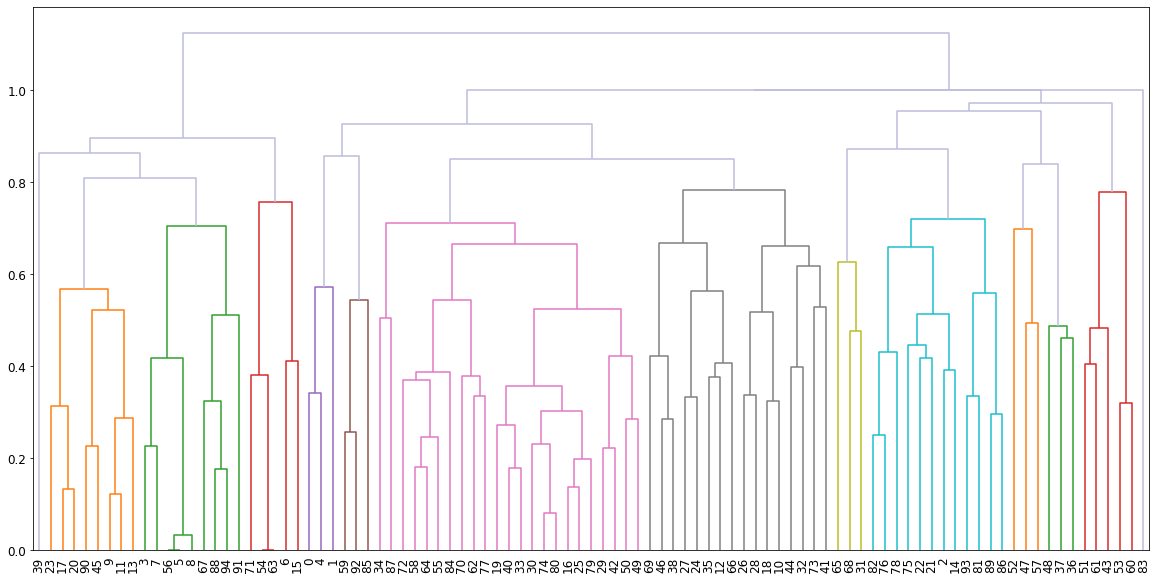

In [11]:
plt.figure(figsize=(20,10))

dn = dendrogram(linkage_matrix, 
                above_threshold_color='#bcbddc',
                leaf_rotation=90.,
                leaf_font_size=12.)  
plt.gca().yaxis.set_tick_params(labelsize='large')

In [12]:
roi_order = list(map(int, dn['ivl'])) #convert from strings to ints
cluster_colors = np.zeros((4, len(roi_order)))

In [34]:
#convert the dendrogram colors to indices we can use for ROI coloring
color_indices = np.zeros((len(dn['leaves_color_list'])))
count = 1
for c in range(len(dn['leaves_color_list'])):
    if dn['leaves_color_list'][c] in "#bcbddc":
        color_indices[c] = 0
    else:
        if c == 0:
            color_indices[c] = count
        else:
            if dn['leaves_color_list'][c] == dn['leaves_color_list'][c-1] or dn['leaves_color_list'][c-1] in "#bcbddc":
                color_indices[c] = count
            else:
                count += 1
                color_indices[c] = count
        

In [38]:
clusters_by_roi = [int(x) for _,x in sorted(zip(roi_order,color_indices))]

In [40]:
#create dict for matlab
ordered_clusters = {}
ordered_clusters['full'] = clusters_by_roi

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj06_rh_400_cluster_testing.mat', ordered_clusters)

In [41]:
first_half_split = dn['ivl'].index('15') +1
q1_split = dn['ivl'].index('91') +1
q3_split = dn['ivl'].index('41') +1

In [42]:
cluster_colors[0,:] = np.hstack((np.repeat(0,first_half_split), np.repeat(1,len(roi_order)-first_half_split)))

In [43]:
cluster_colors[1,:] = np.hstack((np.repeat(0,q1_split), np.repeat(1,first_half_split-q1_split),
                                 np.repeat(2,q3_split-first_half_split),np.repeat(3,len(roi_order)-q3_split)))

In [45]:
cluster_splits = np.zeros_like((cluster_colors))
for c in range(2):
    cluster_splits[c,:] = [x for _,x in sorted(zip(roi_order,cluster_colors[c]))]

#create dict for matlab
ordered_clusters = {}
ordered_clusters['split1'] = cluster_splits[0]
ordered_clusters['split2'] = cluster_splits[1]

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj06_rh_cluster_testing_400.mat', ordered_clusters)

In [74]:
#next split level
s1 = dn['ivl'].index('20') +1
s2 = dn['ivl'].index('63') +1
s3 = dn['ivl'].index('44') +1
s4 = dn['ivl'].index('0') +1
s5 = dn['ivl'].index('5') +1
s6 = dn['ivl'].index('28') +1
s7 = dn['ivl'].index('34') +1
#s8 = end


In [75]:
cluster_colors[2,:] = np.hstack((np.repeat(0,s1), np.repeat(1,s2-s1), np.repeat(2,s3-s2),
                                 np.repeat(3,s4-s3), np.repeat(4,s5-s4), np.repeat(5,s6-s5),
                                 np.repeat(6,s7-s6), np.repeat(7,len(roi_order)-s7)))

In [76]:
#all groups based on dendrogram coloring
g1 = s1 +1
g2 = s2 +1
g3 = s3 +1
g4 = s4 +1
g5 = s5 +1
g6 = dn['ivl'].index('25') +1
g7 = s6 +1
g8 = dn['ivl'].index('42') +1
g9 = dn['ivl'].index('34') +1


In [77]:
cluster_colors[3,:] = np.hstack((np.repeat(1,g1), np.repeat(2,g2-g1), np.repeat(3,g3-g2),
                                 np.repeat(4,g4-g3), np.repeat(5,g5-g4), np.repeat(6,g6-g5),
                                 np.repeat(7,g7-g6), np.repeat(8,g8-g7), np.repeat(9,g9-g8), 
                                 np.repeat(10,len(roi_order)-g9)))
cluster_colors[3,dn['ivl'].index('24')] = 0 #no grouping

In [78]:
cluster_colors

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.,  3.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,
         3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.

In [89]:
clusters_by_roi = np.zeros_like((cluster_colors))

In [90]:
for c in range(4):
    clusters_by_roi[c,:] = [x for _,x in sorted(zip(roi_order,cluster_colors[c]))]

In [91]:
clusters_by_roi

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
         0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  1.,  1.,  2.,  1.,  2.,  0.,  2.,  2.,  0.,  2.,
         1.,  0.,  2.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,
         2.,  3.,  2.,  2.,  0.,  3.,  2.,  2.,  3.,  2.,  3.,  2.,  3.,
         2.,  3.,  2.,  3.,  2.,  1.,  2.,  3.,  2.,  2.,  3.,  3.,  2.,
         0.,  2.,  2.,  0.,  2.,  0.,  1.,  0.,  2.,  2.,  0.,  0.,  1.,
         1.,  1.,  0.,  1.,  0.,  1.],
       [ 3.,  3.,  1.,  3.,  3.,  4.,  3.,  4.,  0.,  5.,  4.,  1.,  5.,
         3.,  0.,  4.,  5.,  0.,  5.,  5.,  0.,  5.,  5.,  0.,  4.,  5.,
         5.,  6.,  5.,  5.,  0.,  6.,  5.,  4.

In [95]:
#create dict for matlab
ordered_clusters = {}
ordered_clusters['split1'] = clusters_by_roi[0]
ordered_clusters['split2'] = clusters_by_roi[1]
ordered_clusters['split3'] = clusters_by_roi[2]
ordered_clusters['split4'] = clusters_by_roi[3]

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj06_rh_cluster_testing.mat', ordered_clusters)

In [26]:
from sklearn.manifold import MDS
x, y = MDS(dissimilarity='precomputed').fit_transform(1-test).T

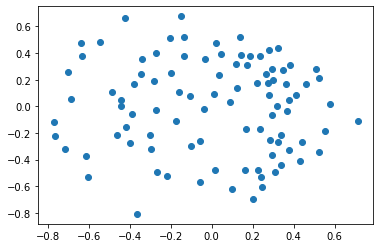

In [27]:
plt.scatter(x, y)

In [28]:
from sklearn.cluster import AffinityPropagation


In [29]:
clustering = AffinityPropagation(affinity='precomputed',random_state=5).fit_predict(test)

In [30]:
affinity_prop = {}
affinity_prop['ap'] = clustering

#save out
save_dir = '../../../local_data/processed'
scipy.io.savemat(save_dir + '/subj06_rh_ap_testing.mat', affinity_prop)

In [31]:
clustering

array([ 1,  3,  0,  9,  1,  7,  1,  7,  7,  7,  2,  7,  3,  7,  0,  7,  4,
        7,  2,  5,  7,  0,  3,  7,  3,  4,  2,  5,  2,  4,  4,  2,  3,  5,
        7, 13,  6,  6,  5,  5,  5, 10,  4,  8, 10,  7,  5,  6,  6,  5,  7,
        8, 10,  8,  9, 10,  7,  6, 10,  3,  8,  8, 10,  9, 10,  8, 10,  7,
       11,  5, 10,  9,  5, 11,  4, 13, 11, 10, 11,  4,  4, 13, 11, 12, 10,
        3, 13,  7,  7, 13,  7,  9,  7, 13,  7])